# Preliminary Results


In [2]:
# Load the necessary packages.
library(tidyverse)
library(infer)
library(cowplot)
library(broom)

-- Attaching packages --------------------------------------- tidyverse 1.3.2 --
v ggplot2 3.3.6      v purrr   0.3.4 
v tibble  3.1.8      v dplyr   1.0.10
v tidyr   1.2.1      v stringr 1.4.1 
v readr   2.1.3      v forcats 0.5.2 
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


In [3]:
#Setting the seed.
set.seed(1234)

#Dowloading the data from the web and reading it in R.
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv"
download.file (url,"../data/forestfires.csv" )

forest_fires_data <-read_delim("../data/forestfires.csv", skip=0, delim=",") %>%
    select(month, wind, area) %>%
    mutate(month = as.factor(month), wind = as.numeric(wind), area = as.numeric(area)) %>% #Wrangling data and selecting columns to be used in prediction
    filter(!is.na(month) | !is.na(wind) | !is.na(area))
    
head(forest_fires_data)


Rows: 517 Columns: 13
-- Column specification --------------------------------------------------------
Delimiter: ","
chr  (2): month, day
dbl (11): X, Y, FFMC, DMC, DC, ISI, temp, RH, wind, rain, area

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


month,wind,area
<fct>,<dbl>,<dbl>
mar,6.7,0
oct,0.9,0
oct,1.3,0
mar,4.0,0
mar,1.8,0
aug,5.4,0


##### Table 1: Top 6 Rows of Forest Fires Data

In [4]:
#Visualizing the summary of the predictor variables.
print(summary(forest_fires_data))

     month          wind            area        
 aug    :184   Min.   :0.400   Min.   :   0.00  
 sep    :172   1st Qu.:2.700   1st Qu.:   0.00  
 mar    : 54   Median :4.000   Median :   0.52  
 jul    : 32   Mean   :4.018   Mean   :  12.85  
 feb    : 20   3rd Qu.:4.900   3rd Qu.:   6.57  
 jun    : 17   Max.   :9.400   Max.   :1090.84  
 (Other): 38                                    


##### Table 2: Summary Statistics of Forest Fires Data

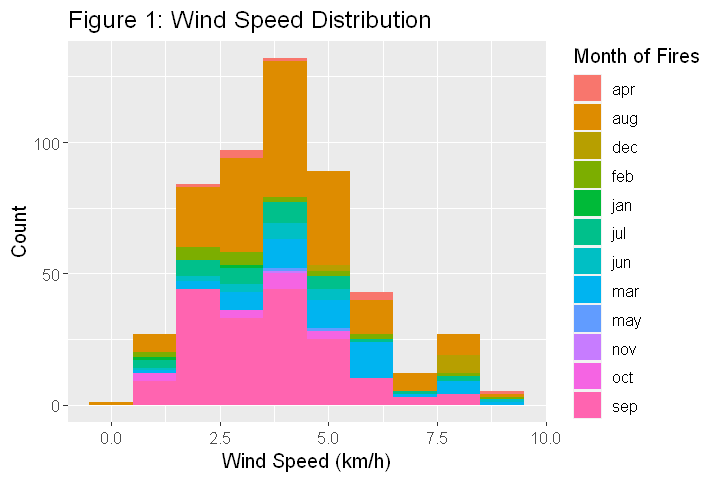

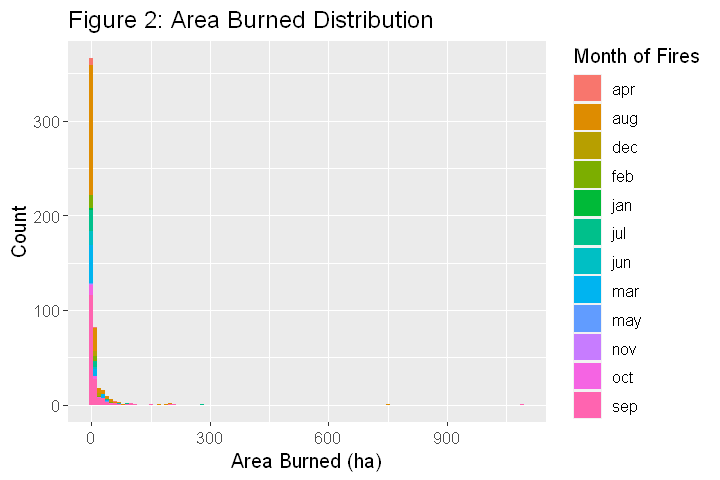

In [11]:
options(repr.plot.width = 6, repr.plot.height = 4)

#Visualizing the distribution of each variable
plot_1 <- forest_fires_data %>%
    ggplot(aes(x = wind, fill = month))+
    geom_histogram(bins = 10) + 
    labs(x="Wind Speed (km/h)", y="Count")+
    ggtitle("Figure 1: Wind Speed Distribution") +
    scale_fill_discrete(name = "Month of Fires")+
    theme(text = element_text(size = 12)) 
plot_1

plot_2 <- forest_fires_data %>%
    ggplot(aes(x =area, fill = month))+
    geom_histogram(binwidth = 10) + 
    labs(x="Area Burned (ha)", y="Count")+
    ggtitle("Figure 2: Area Burned Distribution") +
    scale_fill_discrete(name = "Month of Fires")+
    theme(text = element_text(size = 12))
plot_2



Figure 2 shows that it make sense to scale the data in a logrithmic scale.
> See https://www.programmingr.com/tutorial/log-in-r/.

In [52]:
forest_fires_data <- forest_fires_data %>%
    mutate(area_log10 = log10(area))

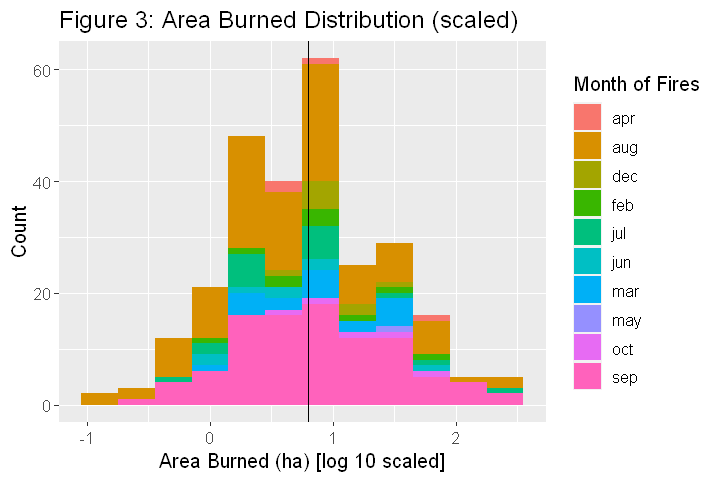

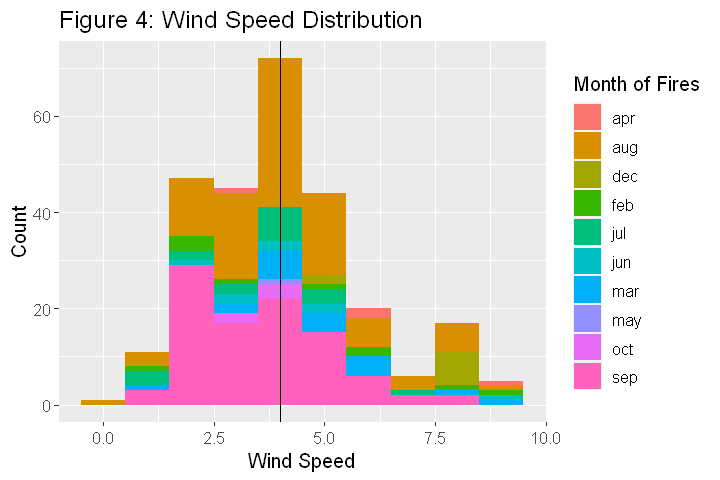

In [55]:
area_burned_plot_2 <- forest_fires_data %>%
    ggplot(aes(x =area_log10, fill = month))+
    geom_histogram(binwidth = 0.3) + 
    labs(x="Area Burned (ha) [log 10 scaled]", y="Count")+
    ggtitle("Figure 3: Area Burned Distribution (scaled)") +
    scale_fill_discrete(name = "Month of Fires") +
    theme(text = element_text(size = 12)) + 
    geom_vline(aes(xintercept = median(area_log10)))
area_burned_plot_2

wind_plot <- forest_fires_data %>%
    ggplot(aes(x =wind, fill = month))+
    geom_histogram(binwidth = 1) + 
    labs(x="Wind Speed", y="Count")+
    ggtitle("Figure 4: Wind Speed Distribution") +
    scale_fill_discrete(name = "Month of Fires") +
    theme(text = element_text(size = 12)) + 
    geom_vline(aes(xintercept = quantile(wind)[3]))
wind_plot

Based on that wind speed is almost a normal distribution (without much modification), we can safely assume that we can categorize wind speed into "high" and "low".

In [58]:
xs <- quantile(forest_fires_data$wind,c(0,1/2,1))

forest_fires_data <- forest_fires_data %>%
    mutate(category=cut(wind, breaks=xs, labels=c("low","high"),include.lowest = TRUE))
head(forest_fires_data)

month,wind,area,area_log10,category
<fct>,<dbl>,<dbl>,<dbl>,<fct>
jul,2.7,0.36,-0.4436975,low
sep,2.2,0.43,-0.3665315,low
sep,1.8,0.47,-0.3279021,low
aug,4.5,0.55,-0.2596373,high
aug,8.9,0.61,-0.2146702,high
jul,5.4,0.71,-0.1487417,high


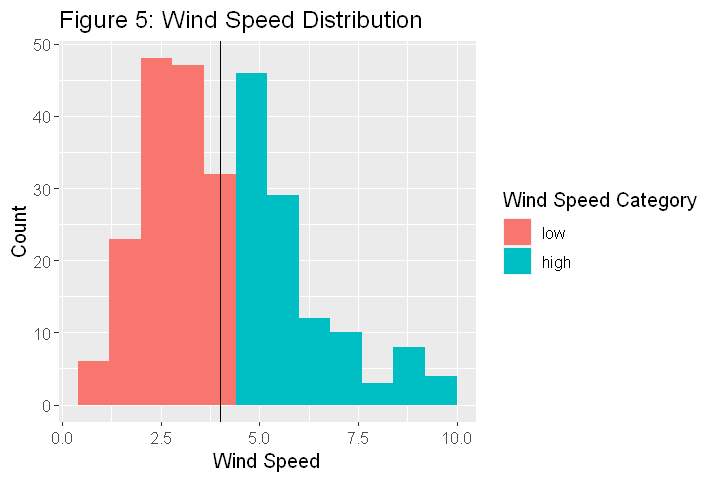

In [65]:
wind_plot_categorized <- forest_fires_data %>%
    ggplot(aes(x =wind, fill = category))+
    geom_histogram(binwidth = 0.8) + 
    labs(x="Wind Speed", y="Count")+
    ggtitle("Figure 5: Wind Speed Distribution") +
    scale_fill_discrete(name = "Wind Speed Category") +
    theme(text = element_text(size = 12)) + 
    geom_vline(aes(xintercept = quantile(wind)[3]))
wind_plot_categorized